In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from __future__ import print_function, absolute_import
import os
import argparse
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import math

In [3]:
cuda = torch.cuda.is_available()

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

dataset = 'cifar10'
batch_size = 64
test_batch_size = 256

if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data.cifar10', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Pad(4),
                           transforms.RandomCrop(32),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data.cifar10', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
else:
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100('./data.cifar100', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Pad(4),
                           transforms.RandomCrop(32),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100('./data.cifar100', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

100%|██████████| 170498071/170498071 [00:01<00:00, 88024372.50it/s]


Extracting ./data.cifar10/cifar-10-python.tar.gz to ./data.cifar10


In [5]:
class channel_selection(nn.Module):
    """
    Select channels from the output of BatchNorm2d layer. It should be put directly after BatchNorm2d layer.
    The output shape of this layer is determined by the number of 1 in `self.indexes`.
    """
    def __init__(self, num_channels):
        """
        Initialize the `indexes` with all one vector with the length same as the number of channels.
        During pruning, the places in `indexes` which correpond to the channels to be pruned will be set to 0.
        """
        super(channel_selection, self).__init__()
        self.indexes = nn.Parameter(torch.ones(num_channels))

    def forward(self, input_tensor):
        """
        Parameter
        ---------
        input_tensor: (N,C,H,W). It should be the output of BatchNorm2d layer.
        """
        selected_index = np.squeeze(np.argwhere(self.indexes.data.cpu().numpy()))
        if selected_index.size == 1:
            selected_index = np.resize(selected_index, (1,)) 
        output = input_tensor[:, selected_index, :, :]
        return output



__all__ = ['resnet']

"""
preactivation resnet with bottleneck design.
"""

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, cfg, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.select = channel_selection(inplanes)
        self.conv1 = nn.Conv2d(cfg[0], cfg[1], kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(cfg[1])
        self.conv2 = nn.Conv2d(cfg[1], cfg[2], kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(cfg[2])
        self.conv3 = nn.Conv2d(cfg[2], planes * 4, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.select(out)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out

class resnet(nn.Module):
    def __init__(self, depth=164, dataset='cifar10', cfg=None):
        super(resnet, self).__init__()
        assert (depth - 2) % 9 == 0, 'depth should be 9n+2'

        n = (depth - 2) // 9
        block = Bottleneck

        if cfg is None:
            # Construct config variable.
            cfg = [[16, 16, 16], [64, 16, 16]*(n-1), [64, 32, 32], [128, 32, 32]*(n-1), [128, 64, 64], [256, 64, 64]*(n-1), [256]]
            cfg = [item for sub_list in cfg for item in sub_list]

        self.inplanes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.layer1 = self._make_layer(block, 16, n, cfg = cfg[0:3*n])
        self.layer2 = self._make_layer(block, 32, n, cfg = cfg[3*n:6*n], stride=2)
        self.layer3 = self._make_layer(block, 64, n, cfg = cfg[6*n:9*n], stride=2)
        self.bn = nn.BatchNorm2d(64 * block.expansion)
        self.select = channel_selection(64 * block.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8)

        if dataset == 'cifar10':
            self.fc = nn.Linear(cfg[-1], 10)
        elif dataset == 'cifar100':
            self.fc = nn.Linear(cfg[-1], 100)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(0.5)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, cfg, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
            )

        layers = []
        layers.append(block(self.inplanes, planes, cfg[0:3], stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, cfg[3*i: 3*(i+1)]))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.bn(x)
        x = self.select(x)
        x = self.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [6]:
refine = ''
depth = 164
lr = 0.1
momentum = 0.9
weight_decay = 1e-4

if refine:
    checkpoint = torch.load(refine)
    model = resnet(dataset=dataset, depth=depth, cfg=checkpoint['cfg'])
    model.load_state_dict(checkpoint['state_dict'])
else:
    model = resnet(dataset=dataset, depth=depth)
    
if cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

resume = ''
start_epoch = 0

if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(resume, checkpoint['epoch'], best_prec1))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

In [7]:
s = 0.0001
sr = ''
log_interval = 100

# additional subgradient descent on the sparsity-induced penalty term
def updateBN():
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1
            
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        pred = output.data.max(1, keepdim=True)[1]
        loss.backward()
        if sr:
            updateBN()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

def save_checkpoint(state, is_best, filepath):
    torch.save(state, os.path.join(filepath, 'checkpoint.pth.tar'))
    if is_best:
        shutil.copyfile(os.path.join(filepath, 'checkpoint.pth.tar'), os.path.join(filepath, 'model_best.pth.tar'))

In [8]:
epochs = 20
save = ''

best_prec1 = 0.
for epoch in range(start_epoch, epochs):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best, filepath=save)

print("Best accuracy: "+str(best_prec1))

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.316646
Train Epoch: 0 [6400/50000 (12.8%)]	Loss: 1.868889
Train Epoch: 0 [12800/50000 (25.6%)]	Loss: 1.745639
Train Epoch: 0 [19200/50000 (38.4%)]	Loss: 1.661745
Train Epoch: 0 [25600/50000 (51.2%)]	Loss: 1.391387
Train Epoch: 0 [32000/50000 (63.9%)]	Loss: 1.334859
Train Epoch: 0 [38400/50000 (76.7%)]	Loss: 1.497894
Train Epoch: 0 [44800/50000 (89.5%)]	Loss: 1.224237

Test set: Average loss: 1.5385, Accuracy: 4726/10000 (47.3%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.073227
Train Epoch: 1 [6400/50000 (12.8%)]	Loss: 1.120586
Train Epoch: 1 [12800/50000 (25.6%)]	Loss: 1.110890
Train Epoch: 1 [19200/50000 (38.4%)]	Loss: 1.128029
Train Epoch: 1 [25600/50000 (51.2%)]	Loss: 0.998251
Train Epoch: 1 [32000/50000 (63.9%)]	Loss: 0.870343
Train Epoch: 1 [38400/50000 (76.7%)]	Loss: 0.916881
Train Epoch: 1 [44800/50000 (89.5%)]	Loss: 1.072088

Test set: Average loss: 1.1484, Accuracy: 5797/10000 (58.0%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.943887
Train E

# **Train with Sparsity**

In [9]:
sr = 'sr'
s = 0.00001
depth = 164

if refine:
    checkpoint = torch.load(refine)
    model = resnet(dataset=dataset, depth=depth, cfg=checkpoint['cfg'])
    model.load_state_dict(checkpoint['state_dict'])
else:
    model = resnet(dataset=dataset, depth=depth)
    
if cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

resume = ''
start_epoch = 0

if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(resume, checkpoint['epoch'], best_prec1))
    else:
        print("=> no checkpoint found at '{}'".format(resume))
        
epochs = 20
save = ''

best_prec1 = 0.
for epoch in range(start_epoch, epochs):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best, filepath=save)

print("Best accuracy: "+str(best_prec1))

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.276196
Train Epoch: 0 [6400/50000 (12.8%)]	Loss: 1.801003
Train Epoch: 0 [12800/50000 (25.6%)]	Loss: 1.618730
Train Epoch: 0 [19200/50000 (38.4%)]	Loss: 1.718458
Train Epoch: 0 [25600/50000 (51.2%)]	Loss: 1.463857
Train Epoch: 0 [32000/50000 (63.9%)]	Loss: 1.289848
Train Epoch: 0 [38400/50000 (76.7%)]	Loss: 1.551985
Train Epoch: 0 [44800/50000 (89.5%)]	Loss: 1.416613

Test set: Average loss: 1.6068, Accuracy: 4556/10000 (45.6%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.228281
Train Epoch: 1 [6400/50000 (12.8%)]	Loss: 1.529305
Train Epoch: 1 [12800/50000 (25.6%)]	Loss: 1.139593
Train Epoch: 1 [19200/50000 (38.4%)]	Loss: 1.189836
Train Epoch: 1 [25600/50000 (51.2%)]	Loss: 1.343126
Train Epoch: 1 [32000/50000 (63.9%)]	Loss: 1.190499
Train Epoch: 1 [38400/50000 (76.7%)]	Loss: 1.191807
Train Epoch: 1 [44800/50000 (89.5%)]	Loss: 0.971528

Test set: Average loss: 1.5823, Accuracy: 4974/10000 (49.7%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.867133
Train E

# **Prune**

In [10]:
# depth = 164
# percent = 0.4
# model_path = '/kaggle/working/model_best.pth.tar'

# model = resnet(depth=depth)

# if cuda:
#     model.cuda()

# if model_path:
#     if os.path.isfile(model_path):
#         print("=> loading checkpoint '{}'".format(model_path))
#         checkpoint = torch.load(model_path)
#         start_epoch = checkpoint['epoch']
#         best_prec1 = checkpoint['best_prec1']
#         model.load_state_dict(checkpoint['state_dict'])
#         print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
#               .format(model_path, checkpoint['epoch'], best_prec1))
#     else:
#         print("=> no checkpoint found at '{}'".format(resume))

In [11]:
# total = 0

# for m in model.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         total += m.weight.data.shape[0]

# bn = torch.zeros(total)
# index = 0
# for m in model.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         size = m.weight.data.shape[0]
#         bn[index:(index+size)] = m.weight.data.abs().clone()
#         index += size

# y, i = torch.sort(bn)
# thre_index = int(total * percent)
# thre = y[thre_index]


# pruned = 0
# cfg = []
# cfg_mask = []
# for k, m in enumerate(model.modules()):
#     if isinstance(m, nn.BatchNorm2d):
#         weight_copy = m.weight.data.abs().clone()
#         mask = weight_copy.gt(thre).float().cuda()
#         pruned = pruned + mask.shape[0] - torch.sum(mask)
#         m.weight.data.mul_(mask)
#         m.bias.data.mul_(mask)
#         cfg.append(int(torch.sum(mask)))
#         cfg_mask.append(mask.clone())
#         print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
#             format(k, mask.shape[0], int(torch.sum(mask))))
#     elif isinstance(m, nn.MaxPool2d):
#         cfg.append('M')

# pruned_ratio = pruned/total

# print('Pre-processing Successful!')

In [12]:
# # simple test model after Pre-processing prune (simple set BN scales to zeros)
# def test(model):
#     kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
#     if dataset == 'cifar10':
#         test_loader = torch.utils.data.DataLoader(
#             datasets.CIFAR10('./data.cifar10', train=False, transform=transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
#             batch_size=test_batch_size, shuffle=False, **kwargs)
#     elif dataset == 'cifar100':
#         test_loader = torch.utils.data.DataLoader(
#             datasets.CIFAR100('./data.cifar100', train=False, transform=transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
#             batch_size=test_batch_size, shuffle=False, **kwargs)
#     else:
#         raise ValueError("No valid dataset is given.")
#     model.eval()
#     correct = 0
#     for data, target in test_loader:
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         with torch.no_grad():
#             data, target = Variable(data), Variable(target)
#         output = model(data)
#         pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#         correct += pred.eq(target.data.view_as(pred)).cpu().sum()

#     print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
#         correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
#     return correct / float(len(test_loader.dataset))

# acc = test(model)

# print("Cfg:")
# print(cfg)

In [13]:
# save = ''
# newmodel = resnet(depth=depth, cfg=cfg)
# if cuda:
#     newmodel.cuda()

# num_parameters = sum([param.nelement() for param in newmodel.parameters()])
# savepath = os.path.join(save, "prune.txt")
# with open(savepath, "w") as fp:
#     fp.write("Configuration: \n"+str(cfg)+"\n")
#     fp.write("Number of parameters: \n"+str(num_parameters)+"\n")
#     fp.write("Test accuracy: \n"+str(acc))

# old_modules = list(model.modules())
# new_modules = list(newmodel.modules())
# layer_id_in_cfg = 0
# start_mask = torch.ones(3)
# end_mask = cfg_mask[layer_id_in_cfg]
# conv_count = 0

In [14]:
# for layer_id in range(len(old_modules)):
#     m0 = old_modules[layer_id]
#     m1 = new_modules[layer_id]
#     if isinstance(m0, nn.BatchNorm2d):
#         idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
#         if idx1.size == 1:
#             idx1 = np.resize(idx1,(1,))

#         if isinstance(old_modules[layer_id + 1], channel_selection):
#             # If the next layer is the channel selection layer, then the current batchnorm 2d layer won't be pruned.
#             m1.weight.data = m0.weight.data.clone()
#             m1.bias.data = m0.bias.data.clone()
#             m1.running_mean = m0.running_mean.clone()
#             m1.running_var = m0.running_var.clone()

#             # We need to set the channel selection layer.
#             m2 = new_modules[layer_id + 1]
#             m2.indexes.data.zero_()
#             m2.indexes.data[idx1.tolist()] = 1.0

#             layer_id_in_cfg += 1
#             start_mask = end_mask.clone()
#             if layer_id_in_cfg < len(cfg_mask):
#                 end_mask = cfg_mask[layer_id_in_cfg]
#         else:
#             m1.weight.data = m0.weight.data[idx1.tolist()].clone()
#             m1.bias.data = m0.bias.data[idx1.tolist()].clone()
#             m1.running_mean = m0.running_mean[idx1.tolist()].clone()
#             m1.running_var = m0.running_var[idx1.tolist()].clone()
#             layer_id_in_cfg += 1
#             start_mask = end_mask.clone()
#             if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
#                 end_mask = cfg_mask[layer_id_in_cfg]
#     elif isinstance(m0, nn.Conv2d):
#         if conv_count == 0:
#             m1.weight.data = m0.weight.data.clone()
#             conv_count += 1
#             continue
#         if isinstance(old_modules[layer_id-1], channel_selection) or isinstance(old_modules[layer_id-1], nn.BatchNorm2d):
#             # This convers the convolutions in the residual block.
#             # The convolutions are either after the channel selection layer or after the batch normalization layer.
#             conv_count += 1
#             idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
#             idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
#             print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
#             if idx0.size == 1:
#                 idx0 = np.resize(idx0, (1,))
#             if idx1.size == 1:
#                 idx1 = np.resize(idx1, (1,))
#             w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()

#             # If the current convolution is not the last convolution in the residual block, then we can change the 
#             # number of output channels. Currently we use `conv_count` to detect whether it is such convolution.
#             if conv_count % 3 != 1:
#                 w1 = w1[idx1.tolist(), :, :, :].clone()
#             m1.weight.data = w1.clone()
#             continue

#         # We need to consider the case where there are downsampling convolutions. 
#         # For these convolutions, we just copy the weights.
#         m1.weight.data = m0.weight.data.clone()
#     elif isinstance(m0, nn.Linear):
#         idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
#         if idx0.size == 1:
#             idx0 = np.resize(idx0, (1,))

#         m1.weight.data = m0.weight.data[:, idx0].clone()
#         m1.bias.data = m0.bias.data.clone()

# torch.save({'cfg': cfg, 'state_dict': newmodel.state_dict()}, os.path.join(save, 'pruned.pth.tar'))

# print(newmodel)
# model = newmodel
# test(model)

# **Fine-tune**

In [15]:
# refine = '/kaggle/working/pruned.pth.tar'
# epochs = 20
# depth = 164

# s = 0.0001
# sr = ''
# log_interval = 100

# # additional subgradient descent on the sparsity-induced penalty term
# def updateBN():
#     for m in model.modules():
#         if isinstance(m, nn.BatchNorm2d):
#             m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1
            
# def train(epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         with torch.no_grad():
#             data, target = Variable(data), Variable(target)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.cross_entropy(output, target)
#         pred = output.data.max(1, keepdim=True)[1]
#         loss.backward()
#         if sr:
#             updateBN()
#         optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
            
# def test():
#     model.eval()
#     test_loss = 0
#     correct = 0
#     for data, target in test_loader:
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         with torch.no_grad():
#             data, target = Variable(data), Variable(target)
#         output = model(data)
#         test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
#         pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#         correct += pred.eq(target.data.view_as(pred)).cpu().sum()

#     test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
#     return correct / float(len(test_loader.dataset))

# def save_checkpoint(state, is_best, filepath):
#     torch.save(state, os.path.join(filepath, 'checkpoint.pth.tar'))
#     if is_best:
#         shutil.copyfile(os.path.join(filepath, 'checkpoint.pth.tar'), os.path.join(filepath, 'model_best.pth.tar'))


# if refine:
#     checkpoint = torch.load(refine)
#     model = resnet(dataset=dataset, depth=depth, cfg=checkpoint['cfg'])
#     model.load_state_dict(checkpoint['state_dict'])
# else:
#     model = resnet(dataset=dataset, depth=depth)
    
# if cuda:
#     model.cuda()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# resume = ''
# start_epoch = 0

# if resume:
#     if os.path.isfile(resume):
#         print("=> loading checkpoint '{}'".format(resume))
#         checkpoint = torch.load(resume)
#         start_epoch = checkpoint['epoch']
#         best_prec1 = checkpoint['best_prec1']
#         model.load_state_dict(checkpoint['state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer'])
#         print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
#               .format(resume, checkpoint['epoch'], best_prec1))
#     else:
#         print("=> no checkpoint found at '{}'".format(resume))
        
# epochs = 20
# save = ''

# best_prec1 = 0.
# for epoch in range(start_epoch, epochs):
#     if epoch in [epochs*0.5, epochs*0.75]:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] *= 0.1
#     train(epoch)
#     prec1 = test()
#     is_best = prec1 > best_prec1
#     best_prec1 = max(prec1, best_prec1)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': model.state_dict(),
#         'best_prec1': best_prec1,
#         'optimizer': optimizer.state_dict(),
#     }, is_best, filepath=save)

# print("Best accuracy: "+str(best_prec1))

# **Pruning with different percent values**

Iteration:  0 Percent:  0
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 19) Prec1: 0.895400
layer index: 4 	 total channel: 16 	 remaining channel: 16
layer index: 7 	 total channel: 16 	 remaining channel: 16
layer index: 9 	 total channel: 16 	 remaining channel: 16
layer index: 15 	 total channel: 64 	 remaining channel: 64
layer index: 18 	 total channel: 16 	 remaining channel: 16
layer index: 20 	 total channel: 16 	 remaining channel: 16
layer index: 24 	 total channel: 64 	 remaining channel: 64
layer index: 27 	 total channel: 16 	 remaining channel: 16
layer index: 29 	 total channel: 16 	 remaining channel: 16
layer index: 33 	 total channel: 64 	 remaining channel: 64
layer index: 36 	 total channel: 16 	 remaining channel: 16
layer index: 38 	 total channel: 16 	 remaining channel: 16
layer index: 42 	 total channel: 64 	 remaining channel: 64
layer index: 45 	 total channel: 16 	 remaining chann

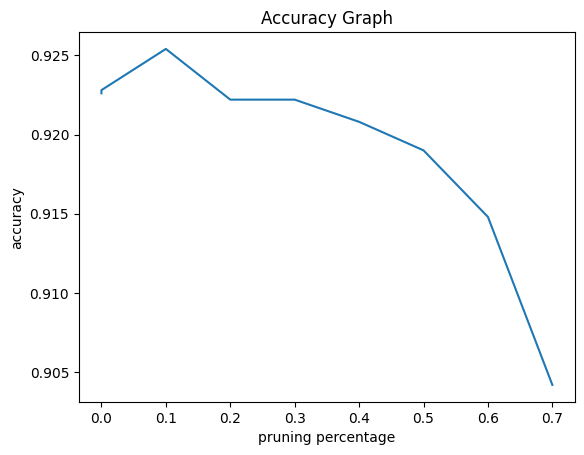

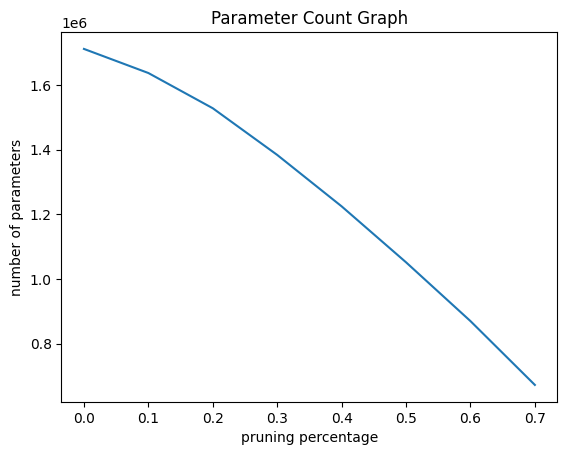

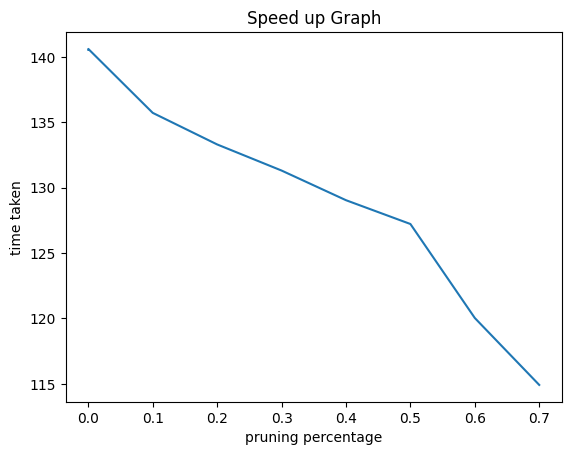

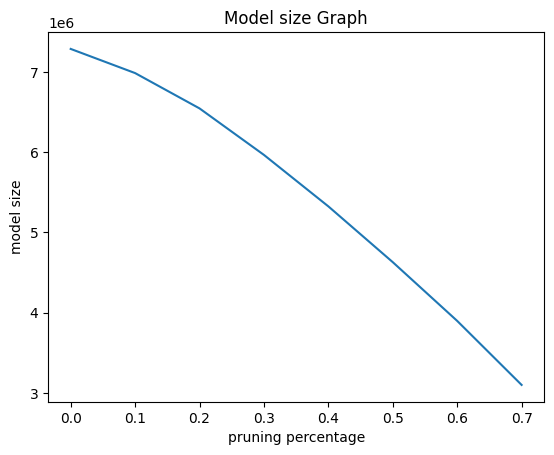

In [16]:
percent_arr = [0,0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
percent_accuracy_list = []
percent_num_param_list = []
percent_model_size_list = []
percent_elapsed_time_list = []
model_path = '/kaggle/working/model_best.pth.tar'
save = 'pruned.pth.tar'

for idx, percent in enumerate(percent_arr):
    print('Iteration: ', idx, 'Percent: ', percent)
    
    depth = 164
    model_path = '/kaggle/working/model_best.pth.tar'

    model = resnet(depth=depth)

    if cuda:
        model.cuda()

    if model_path:
        if os.path.isfile(model_path):
            print("=> loading checkpoint '{}'".format(model_path))
            checkpoint = torch.load(model_path)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
                  .format(model_path, checkpoint['epoch'], best_prec1))
        else:
            print("=> no checkpoint found at '{}'".format(resume))
            
    total = 0

    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            total += m.weight.data.shape[0]

    bn = torch.zeros(total)
    index = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            size = m.weight.data.shape[0]
            bn[index:(index+size)] = m.weight.data.abs().clone()
            index += size

    y, i = torch.sort(bn)
    thre_index = int(total * percent)
    thre = y[thre_index]


    pruned = 0
    cfg = []
    cfg_mask = []
    for k, m in enumerate(model.modules()):
        if isinstance(m, nn.BatchNorm2d):
            weight_copy = m.weight.data.abs().clone()
            mask = weight_copy.gt(thre).float().cuda()
            pruned = pruned + mask.shape[0] - torch.sum(mask)
            m.weight.data.mul_(mask)
            m.bias.data.mul_(mask)
            cfg.append(int(torch.sum(mask)))
            cfg_mask.append(mask.clone())
            print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
                format(k, mask.shape[0], int(torch.sum(mask))))
        elif isinstance(m, nn.MaxPool2d):
            cfg.append('M')

    pruned_ratio = pruned/total

    print('Pre-processing Successful!')
    
    # simple test model after Pre-processing prune (simple set BN scales to zeros)
    def test(model):
        kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
        if dataset == 'cifar10':
            test_loader = torch.utils.data.DataLoader(
                datasets.CIFAR10('./data.cifar10', train=False, transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
                batch_size=test_batch_size, shuffle=False, **kwargs)
        elif dataset == 'cifar100':
            test_loader = torch.utils.data.DataLoader(
                datasets.CIFAR100('./data.cifar100', train=False, transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
                batch_size=test_batch_size, shuffle=False, **kwargs)
        else:
            raise ValueError("No valid dataset is given.")
        model.eval()
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
            correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        return correct / float(len(test_loader.dataset))

    acc = test(model)

    print("Cfg:")
    print(cfg)
    
    save = ''
    newmodel = resnet(depth=depth, cfg=cfg)
    if cuda:
        newmodel.cuda()

    num_parameters = sum([param.nelement() for param in newmodel.parameters()])
    savepath = os.path.join(save, "prune.txt")
    with open(savepath, "w") as fp:
        fp.write("Configuration: \n"+str(cfg)+"\n")
        fp.write("Number of parameters: \n"+str(num_parameters)+"\n")
        fp.write("Test accuracy: \n"+str(acc))

    old_modules = list(model.modules())
    new_modules = list(newmodel.modules())
    layer_id_in_cfg = 0
    start_mask = torch.ones(3)
    end_mask = cfg_mask[layer_id_in_cfg]
    conv_count = 0
    
    for layer_id in range(len(old_modules)):
        m0 = old_modules[layer_id]
        m1 = new_modules[layer_id]
        if isinstance(m0, nn.BatchNorm2d):
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            if idx1.size == 1:
                idx1 = np.resize(idx1,(1,))

            if isinstance(old_modules[layer_id + 1], channel_selection):
                # If the next layer is the channel selection layer, then the current batchnorm 2d layer won't be pruned.
                m1.weight.data = m0.weight.data.clone()
                m1.bias.data = m0.bias.data.clone()
                m1.running_mean = m0.running_mean.clone()
                m1.running_var = m0.running_var.clone()

                # We need to set the channel selection layer.
                m2 = new_modules[layer_id + 1]
                m2.indexes.data.zero_()
                m2.indexes.data[idx1.tolist()] = 1.0

                layer_id_in_cfg += 1
                start_mask = end_mask.clone()
                if layer_id_in_cfg < len(cfg_mask):
                    end_mask = cfg_mask[layer_id_in_cfg]
            else:
                m1.weight.data = m0.weight.data[idx1.tolist()].clone()
                m1.bias.data = m0.bias.data[idx1.tolist()].clone()
                m1.running_mean = m0.running_mean[idx1.tolist()].clone()
                m1.running_var = m0.running_var[idx1.tolist()].clone()
                layer_id_in_cfg += 1
                start_mask = end_mask.clone()
                if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                    end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Conv2d):
            if conv_count == 0:
                m1.weight.data = m0.weight.data.clone()
                conv_count += 1
                continue
            if isinstance(old_modules[layer_id-1], channel_selection) or isinstance(old_modules[layer_id-1], nn.BatchNorm2d):
                # This convers the convolutions in the residual block.
                # The convolutions are either after the channel selection layer or after the batch normalization layer.
                conv_count += 1
                idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
                idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
                print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
                if idx0.size == 1:
                    idx0 = np.resize(idx0, (1,))
                if idx1.size == 1:
                    idx1 = np.resize(idx1, (1,))
                w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()

                # If the current convolution is not the last convolution in the residual block, then we can change the 
                # number of output channels. Currently we use `conv_count` to detect whether it is such convolution.
                if conv_count % 3 != 1:
                    w1 = w1[idx1.tolist(), :, :, :].clone()
                m1.weight.data = w1.clone()
                continue

            # We need to consider the case where there are downsampling convolutions. 
            # For these convolutions, we just copy the weights.
            m1.weight.data = m0.weight.data.clone()
        elif isinstance(m0, nn.Linear):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))

            m1.weight.data = m0.weight.data[:, idx0].clone()
            m1.bias.data = m0.bias.data.clone()

    torch.save({'cfg': cfg, 'state_dict': newmodel.state_dict()}, os.path.join(save, 'pruned.pth.tar'))
    
    num_parameters = sum([param.nelement() for param in newmodel.parameters()])
    percent_num_param_list.append(num_parameters)
    
    file_size = os.path.getsize('pruned.pth.tar')
    percent_model_size_list.append(file_size)
    
    print(newmodel)
    model = newmodel
    test(model)
    
    
    refine = '/kaggle/working/pruned.pth.tar'
    epochs = 20
    depth = 164

    s = 0.0001
    sr = ''
    log_interval = 100

    # additional subgradient descent on the sparsity-induced penalty term
    def updateBN():
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1

    def train(epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            loss.backward()
            if sr:
                updateBN()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

    def test():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        return correct / float(len(test_loader.dataset))

    def save_checkpoint(state, is_best, filepath):
        torch.save(state, os.path.join(filepath, 'checkpoint_refined.pth.tar'))
        if is_best:
            shutil.copyfile(os.path.join(filepath, 'checkpoint_refined.pth.tar'), os.path.join(filepath, 'model_best_refined.pth.tar'))


    if refine:
        checkpoint = torch.load(refine)
        model = resnet(dataset=dataset, depth=depth, cfg=checkpoint['cfg'])
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model = resnet(dataset=dataset, depth=depth)

    if cuda:
        model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    resume = ''
    start_epoch = 0

    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
                  .format(resume, checkpoint['epoch'], best_prec1))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    epochs = 20
    save = ''

    elapsed_time = 0.
    best_prec1 = 0.
    for epoch in range(start_epoch, epochs):
        start_time = time.time()
        if epoch in [epochs*0.5, epochs*0.75]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        train(epoch)
        prec1 = test()
        end_time = time.time()
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, is_best, filepath=save)
        elapsed_time += end_time - start_time
    elapsed_time /= epochs
    print("Best accuracy: "+str(best_prec1))
    print("Number of parameters: "+str(num_parameters))
    percent_elapsed_time_list.append(elapsed_time)
    print("Average Time taken: "+str(elapsed_time))
    percent_accuracy_list.append(best_prec1)
    
    


plt.plot(percent_arr, percent_accuracy_list)
plt.xlabel('pruning percentage')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()

plt.plot(percent_arr, percent_num_param_list)
plt.xlabel('pruning percentage')
plt.ylabel('number of parameters')
plt.title('Parameter Count Graph')
plt.show()

plt.plot(percent_arr, percent_elapsed_time_list)
plt.xlabel('pruning percentage')
plt.ylabel('time taken')
plt.title('Speed up Graph')
plt.show()

plt.plot(percent_arr, percent_model_size_list)
plt.xlabel('pruning percentage')
plt.ylabel('model size')
plt.title('Model size Graph')
plt.show()